In [10]:
import pandas as pd
import talib as ta
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans 

import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib
import warnings
import logging
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.WARNING)  # 设置 matplotlib 日志级别为 WARNING
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib.font_manager")

matplotlib.rcParams['font.family']= 'Songti SC'  # 使用黑体-简
matplotlib.rcParams['axes.unicode_minus'] = False # 解决负号显示问题

In [11]:

def iso_forest_detect(series):
    model = IsolationForest(
        contamination=0.0005,  # 预期异常比例
        random_state=42
    )
    X = series.values.reshape(-1,1)
    return model.fit_predict(X) == -1
def create_features(df):
    """创建特征"""
    df['SMA'] = df['close'].rolling(window=20).mean()
def plot_anomalies(series, anomalies, title):
    plt.figure(figsize=(16, 6))
    # 主序列
    ax = series.plot(label='Normal', alpha=0.8,linewidth=1.2)
    
    # 异常点（确保索引对齐）
    anomaly_points = series.loc[anomalies]
    anomaly_points.plot(
        ax=ax,
        style='D',
        markersize=12,
        color='#FF4500',  # 使用更醒目的橙色
        label='Anomaly',
        alpha=0.9
    )
    # 添加异常密度热力图
    if len(anomaly_points) > 0:
        sns.kdeplot(
            x=anomaly_points.index.astype(np.int64), 
            y=anomaly_points.values,
            cmap='Reds',
            fill=True,
            alpha=0.2,
            ax=ax
        )
    plt.title(f'{title} Anomaly Detection\n(异常率：{anomalies.mean():.2%})', pad=20)
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 添加统计信息框
    stats_text = f"""异常点统计：
    • 总数：{anomalies.sum()}
    • 异常率：{anomalies.mean():.2%}
    """
    
    plt.annotate(stats_text, 
                xy=(0.78, 0.85), 
                xycoords='axes fraction',
                bbox=dict(boxstyle="round", fc="white", ec="#999999", alpha=0.8))
    plt.show()

findfont: Font family 'Songti SC' not found.
findfont: Font family 'Songti SC' not found.
findfont: Font family 'Songti SC' not found.
findfont: Font family 'Songti SC' not found.
findfont: Font family 'Songti SC' not found.
findfont: Font family 'Songti SC' not found.
findfont: Font family 'Songti SC' not found.
findfont: Font family 'Songti SC' not found.
findfont: Font family 'Songti SC' not found.
findfont: Font family 'Songti SC' not found.
c:\Users\liufa\.pyenv\pyenv-win\versions\3.9.13\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 24322 (\N{CJK UNIFIED IDEOGRAPH-5F02}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\liufa\.pyenv\pyenv-win\versions\3.9.13\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 24120 (\N{CJK UNIFIED IDEOGRAPH-5E38}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\liufa\.pyenv\pyenv-win\versions\3.9.13\lib\site-packages\IPython\core\pylabto

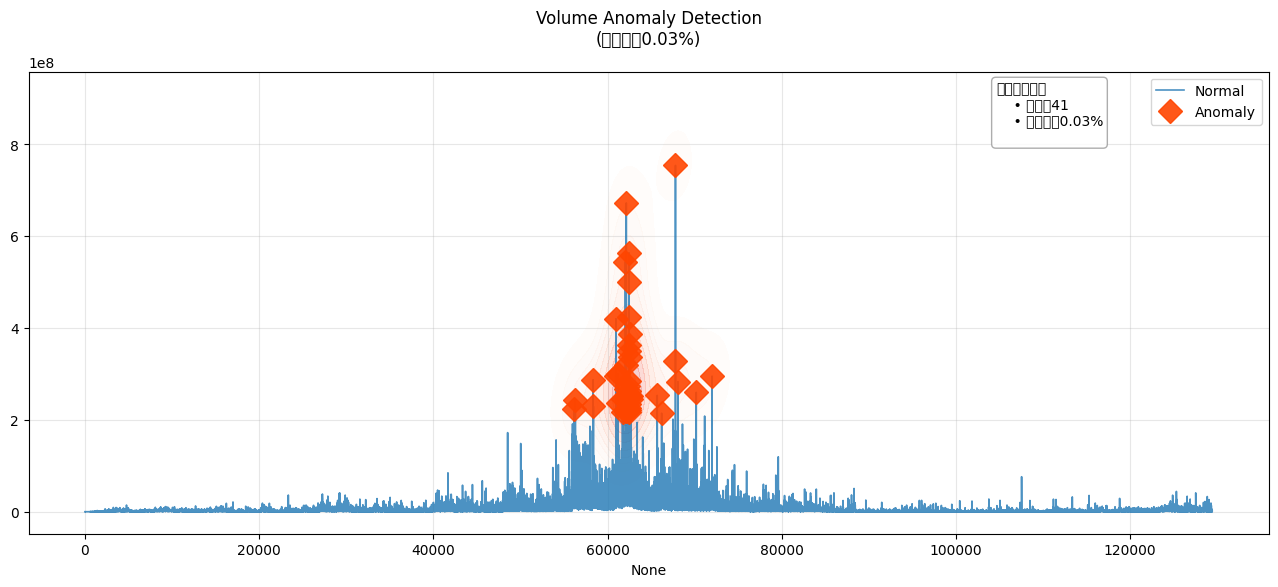

C:\Users\liufa\AppData\Local\Temp\ipykernel_33984\99135767.py:9: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data.loc[iso_forest_anomalies] = data.loc[iso_forest_anomalies].interpolate() # 使用线性插值填充异常值


In [12]:
df = pd.read_csv('stock.csv', parse_dates=True)
# df.index = pd.to_datetime(df.index)
iso_forest_anomalies = iso_forest_detect(df['volume'])

plot_anomalies(df['volume'], iso_forest_anomalies, 'Volume')

data = df.copy()
data.loc[iso_forest_anomalies]=np.nan
data.loc[iso_forest_anomalies] = data.loc[iso_forest_anomalies].interpolate() # 使用线性插值填充异常值

C:\Users\liufa\AppData\Local\Temp\ipykernel_33984\2502844393.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
findfont: Font family 'Songti SC' not found.
findfont: Font family 'Songti SC' not found.
findfont: Font family 'Songti SC' not found.
findfont: Font family 'Songti SC' not found.
findfont: Font family 'Songti SC' not found.
findfont: Font family 'Songti SC' not found.
findfont: Font family 'Songti SC' not found.
findfont: Font family 'Songti SC' not found.
findfont: Font family 'Songti SC' not found.
findfont: Font family 'Songti SC' not found.
findfont: Font family 'Songti SC' not found.
findfont: Font family 'Songti SC' not found.
findfont: Font family 'Songti SC' not found.
findfont: Font family 'Songti SC' not found.
findfont: Font family 'Songti SC' not found.
findfont: Font family 'Songti SC' not found.
findfont: Font family 'Songt

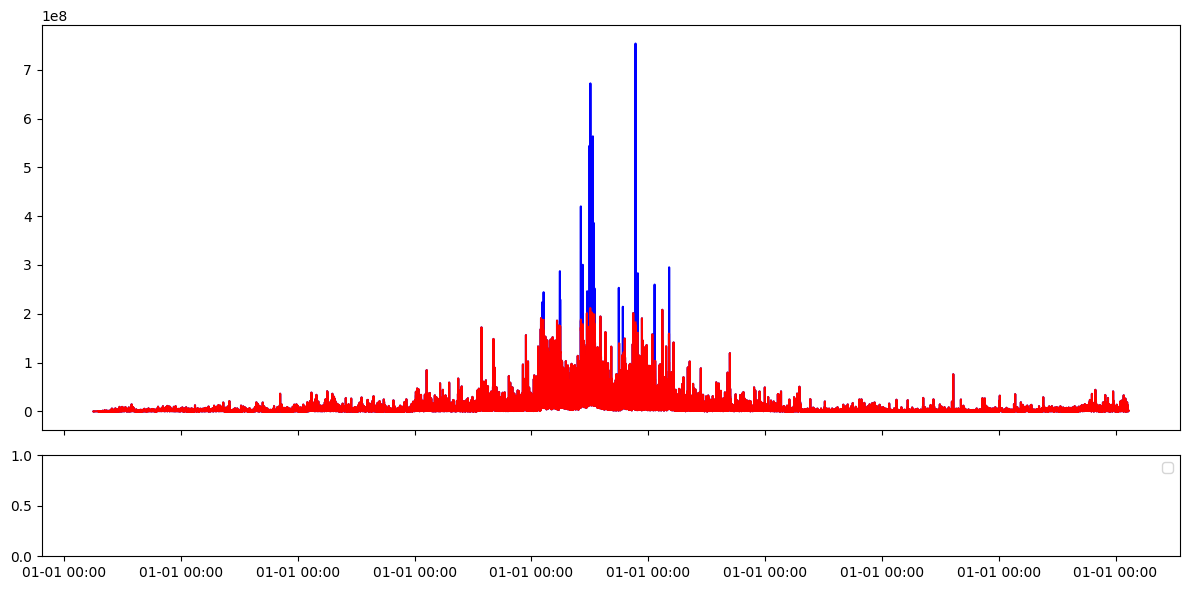

In [13]:
fig, (ax1, ax2) = plt.subplots(2,1,sharex=True,  figsize=(12,6),height_ratios=[4, 1])
ax1.plot(df['volume'], label='Origin Volume', color='blue')

# ax2 = ax1.twinx()
ax1.plot(data['volume'], label='Predicted Volume', color='red')

ax1.xaxis.set_major_locator(mdates.AutoDateLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d %H:%M"))
plt.legend()
plt.tight_layout()
plt.show()


In [14]:
def process_peak_valley(data, window_size=10):
    """
    处理数据，识别峰值和谷值，并进行聚类分析。
    """
    data['ma_center'] = data['close'].rolling(window_size, center=True).mean()
    data.fillna(0, inplace=True)

    features = data[['close','open','ma_center']].copy()
    # 计算移动平均中心点
    # 一阶差分（梯度计算）
    features['diff'] = features['ma_center'].diff()

    # 二阶差分（曲率分析）
    features['diff2'] = features['diff'].diff()

    # 识别条件：一阶导数为零且二阶导数为负（峰值），反之为谷值
    features['peak'] = (features['diff'].abs() < 0.01) & (features['diff2'] < 0)  # 0.01为梯度阈值
    features['valley'] = (features['diff'].abs() < 0.01) & (features['diff2'] > 0)
    # 去除边缘效应
    features = features.dropna()

    # features
    # 保留原有聚类分析 ================
    kmeans = KMeans(n_clusters=10, random_state=0)
    features['cluster'] = kmeans.fit_predict(features)

    # 综合检测结果 ================
    data['final_peak'] = features['peak'] | (features['close'] == features['close'].rolling(window_size, center=True).max())
    data['final_valley'] = features['valley'] | (features['close'] == features['close'].rolling(window_size, center=True).min())
    # data[['final_peak', 'final_valley']].fillna(False, inplace=True)
    # data.fillna(0, inplace=True)
    # data['final_peak'] = data['final_peak'].astype(int)
    # data['final_valley'] = data['final_valley'].astype(int)
    # 计算最终结果
    # data['final_peak'] = features['final_peak']
    # data['final_valley'] = features['final_valley']
    # data['ma_center'] = features['ma_center']
    return data
def plot_stock(df, n=100):
    plt.rcParams['font.sans-serif'] = ['SimHei','DejaVu Sans','Bitstream Vera Sans','Arial Serif','freeserif','sans-serif']
    plt.rcParams['axes.unicode_minus'] = False
    looksize =n
    look_df = df[-looksize:]
    tIndex = df.index[-looksize:]
    _, (ax1, ax2) = plt.subplots(2,1,sharex=True,  figsize=(12,6),height_ratios=[4, 1])
    ax1.plot(tIndex, look_df['close'], color='blue', label='Close MSE')
#     ax1.plot(tIndex, look_df['ma_center'], color='blue', linestyle='--', label=f'MA{window_size}')
    # ax3 = ax1.twinx()
    # ax3.plot(tIndex, look_df['RSI'], color='green', label='RSI')   
       # 标记最终结果
    ax1.scatter(tIndex[look_df['final_peak'] ==1], look_df['close'][look_df['final_peak'] ==1], 
              color='red', marker='x', s=100, label='Peaks')
    ax1.scatter(tIndex[look_df['final_valley'] ==1], look_df['close'][look_df['final_valley'] ==1],
            color='green', marker='o', s=100, label='Valleys')
    ax1.scatter(look_df[look_df['top_divergence'].shift(-2)==1].index, 
           look_df['close'][look_df['top_divergence'].shift(-2)==1], 
           color='red', marker='v', s=60, zorder=2, label='Top Divergences')
    
    ax1.scatter(look_df[look_df['bottom_divergence']==1].index, 
           look_df['close'][look_df['bottom_divergence']==1], 
           color='pink', marker='^', s=60,zorder=2, label='Bottom Divergences')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.legend(loc='upper left')

    ax2.plot(tIndex, look_df['MACD'], color='red', label='MACD')
    ax2.plot(tIndex, look_df['Signal'], color='purple', label='Signal')
    ax2.bar(tIndex, look_df['Hist'], color='gray', label='Hist')

    ax1.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d %H:%M"))
    plt.legend()
    plt.tight_layout()
    plt.show()

In [15]:
def create_features(df:pd.DataFrame):
    data['EMA20'] = ta.EMA(df['close'], timeperiod=20)
    data['EMA100'] = ta.EMA(df['close'], timeperiod=100)
    data['SMA20'] = ta.SMA(df['close'], timeperiod=20)
    data['SMA100'] = ta.SMA(df['close'], timeperiod=100)

    df['RSI'] = ta.RSI(df['close'], timeperiod=14)
    # 平均真实波幅
    df['ATR'] = ta.ATR(df['high'], df['low'], df['close'], timeperiod=14)
    # 波动率
    df['Volatility'] = df['ATR'] / df['close']
    df['MACD'], df['Signal'], df['Hist'] = ta.MACD(df['close'], fastperiod=12, slowperiod=26, signalperiod=9)
    # MACD线瞬时斜率
    df['macd_slope'] = df['MACD'].diff()
    # 移动平均斜率（捕捉趋势强度）
    for window in [3, 5, 10]:
        df[f'macd_slope_ma{window}'] = df['macd_slope'].rolling(window).mean()
    data[['final_peak', 'final_valley']].fillna(value=False)
    df['bottom_divergence'] = (df['final_valley'] == 1 & (df['macd_slope_ma3'] > 0)).astype(int)
    
    df['top_divergence'] = (df['final_peak'] == 1 & 
                                (df['macd_slope_ma3'] < 0)).astype(int)
    # 计算价格波动率
    # 对数收益率滚动标准差
    data['close_volatility'] = np.log(df['close'] / df['close'].shift(1))
    data['Volatility_10'] = data['close_volatility'].rolling(window=10).std() * np.sqrt(10)
    data['close_Volume_volatility'] = data['close_volatility'] * data['volume']
    data['Volume_volatility_10'] = data['close_Volume_volatility'].rolling(window=10).std() * np.sqrt(10)
    # 计算布林带
    df['UpperBB'],df['MiddleBB'],df['LowerBB'] = ta.BBANDS(df['close'], timeperiod=20)

    # 特征工程
    for lag in [1, 3, 5]:
        data[f'return_lag{lag}'] = data['close'].pct_change(lag)
    # 计算趋势线
    seasonal_decompose = sm.tsa.seasonal_decompose(df['close'], model='additive', period=96) 
    df['trend'] = seasonal_decompose.trend
    df['seasonal'] = seasonal_decompose.seasonal
    df['residual'] = seasonal_decompose.resid
    return df.dropna()

C:\Users\liufa\AppData\Local\Temp\ipykernel_33984\2775987743.py:18: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data[['final_peak', 'final_valley']].fillna(value=False)
c:\Users\liufa\.pyenv\pyenv-win\versions\3.9.13\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
findfont: Font family 'Songti SC' not found.
findfont: Font family 'Songti SC' not found.
findfont: Font family 'Songti SC' not found.
findfont: Font family 'Songti SC' not found.
findfont: Font family 'Songti SC' not found.
findfont: Font family 'Songti SC' not found.
findfont: Font family 'Songti SC' not found.
findfont: Font family 'Songti SC' not found.
findfont: Font family 'Songti SC' not found.
findf

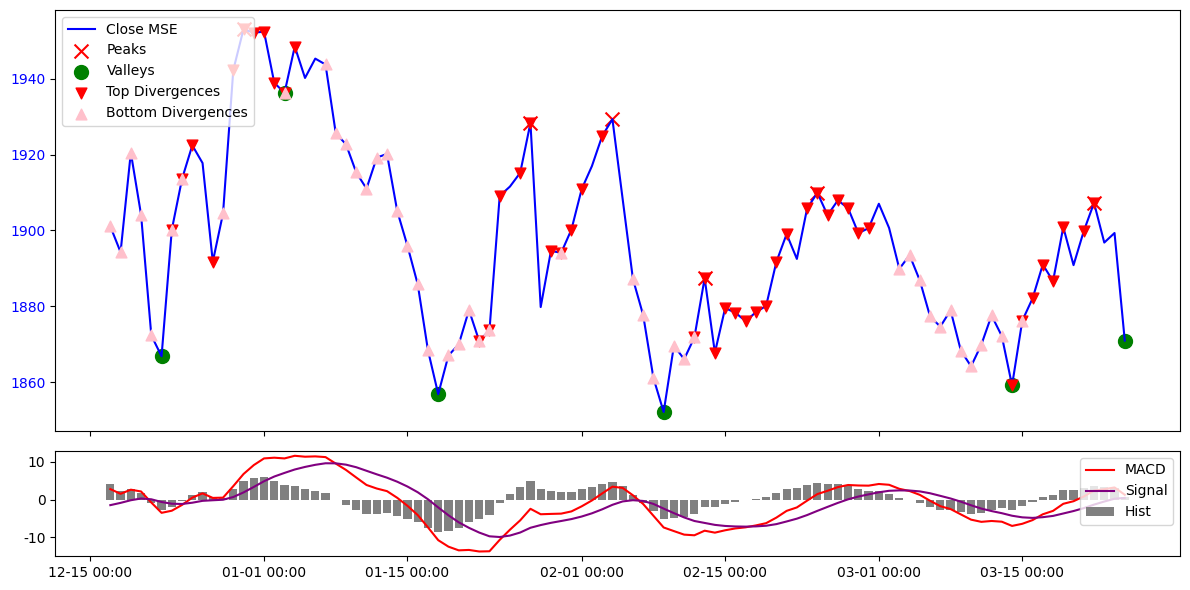

,date,open,close,low,high,volume,count,amount,ma_center,final_peak,...,Volume_volatility_10,UpperBB,MiddleBB,LowerBB,return_lag1,return_lag3,return_lag5,trend,seasonal,residual
99,2017-10-28 13:30:00,292.37,292.74,292.37,292.75,160.682134,20.0,0.5489,292.851,0,...,20.221269,298.296695,294.6315,290.966305,0.001300,0.001437,-0.007560,293.829792,1.430441,-2.520232
100,2017-10-28 14:00:00,292.73,291.96,291.86,292.75,176.740890,22.0,0.6049,292.570,0,...,2.280677,298.160943,294.4110,290.661057,-0.002664,-0.002630,-0.002562,293.823073,1.682651,-3.545724
101,2017-10-28 14:30:00,291.97,292.91,291.20,294.59,234.267629,22.0,0.8014,292.508,0,...,2.320067,297.903752,294.2305,290.557248,0.003254,0.001881,0.002018,293.812812,1.572097,-2.474910
102,2017-10-28 15:00:00,292.94,292.94,291.29,294.58,133.953471,21.0,0.4573,292.486,1,...,2.177855,297.630285,294.0575,290.484715,0.000102,0.000683,0.000717,293.816875,1.574922,-2.451797
103,2017-10-28 15:30:00,292.89,292.87,291.20,292.89,271.680139,23.0,0.9288,292.427,0,...,1.628303,297.295646,293.8750,290.454354,-0.000239,0.003117,0.001744,293.834063,1.126305,-2.090367


In [16]:
data = create_features(process_peak_valley(data))
data['final_peak'] = data['final_peak'].astype(int)
data['final_valley'] = data['final_valley'].astype(int)

plot_stock(data, n=100)
data.head()

In [17]:
data.to_csv('stock_features.csv')